In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

In [75]:
!pip install yt-dlp opencv-python-headless deepface google-api-python-client isodate

Engagement Score Computation - mix of Likes, Views and Comments

In [82]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import isodate

df = pd.read_csv('video_data_final (128vids).csv')

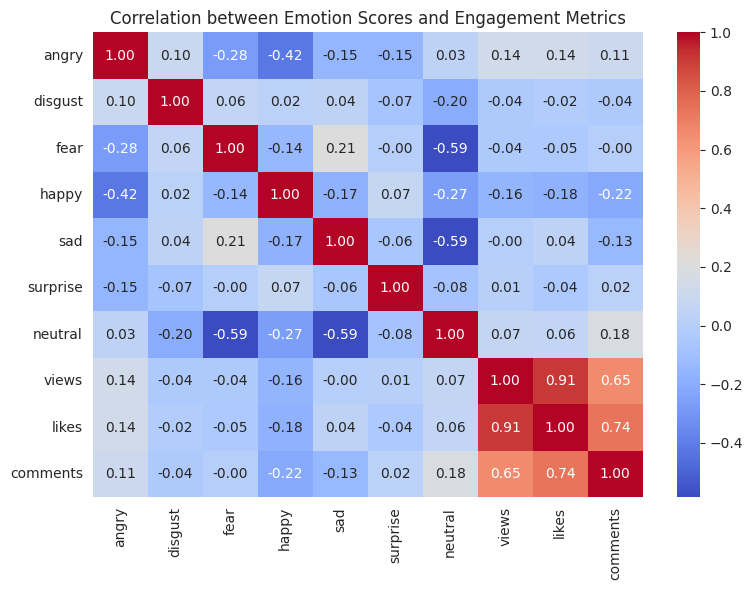

In [83]:
# Select emotion and metric columns
emotion_cols = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
metric_cols = ['views', 'likes', 'comments']

# Compute correlation matrix between emotions and engagement metrics
corr_matrix = df[emotion_cols + metric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation between Emotion Scores and Engagement Metrics")
plt.tight_layout()
plt.show()

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['views_norm', 'likes_norm', 'comments_norm']] = scaler.fit_transform(df[['views', 'likes', 'comments']])

df['engagement_score'] = 0.33 * df['likes_norm'] + 0.33 * df['comments_norm'] + 0.34 * df['views_norm']
# this gives us a single, slightly interpretable (higher = better) value to analyse effect

# simple aggregations of facial expression and of title senitment to
df['pos_emotion'] = df['happy'] + df['surprise']
df['neg_emotion'] = df['angry'] + df['disgust'] + df['fear'] + df['sad']
df['emotional_intensity'] = 1 - (df['neutral'] / 100)

# also simple logical aggregation of title sentiment
df['title_sentiment'] = (
    df['title is exaggerated'] +
    df['title is emotionally touching'] -
    df['title is plain']
)

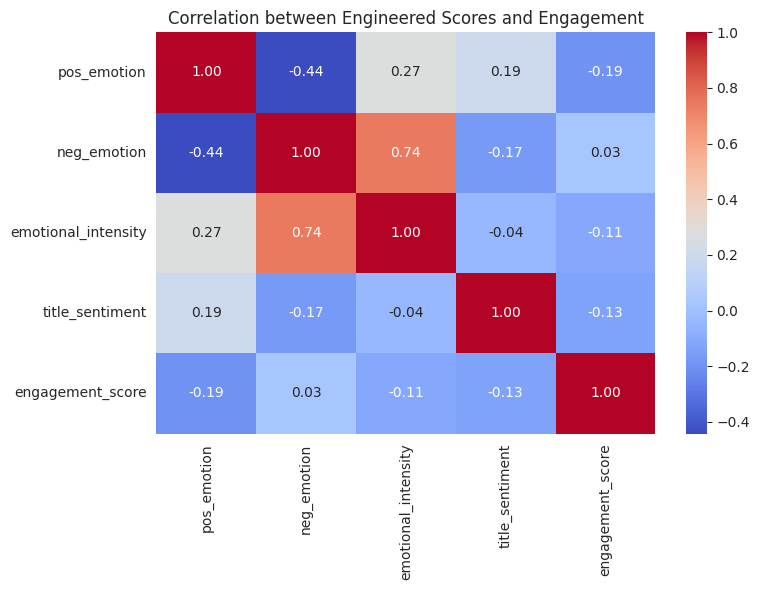

In [85]:
engineered_emotions = ['pos_emotion', 'neg_emotion', 'emotional_intensity']

corr_matrix = df[engineered_emotions + ['title_sentiment'] + ['engagement_score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation between Engineered Scores and Engagement")
plt.tight_layout()
plt.show()

In [86]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# run simple OLS models on aggregated emotional scores to compare singular influences
vars_to_run = ['pos_emotion', 'neg_emotion', 'neutral']

results = {}
for v in vars_to_run:
    Xv = sm.add_constant(df[[v]])
    results[v] = sm.OLS(df['views_norm'], Xv).fit()

# turn the dict‐views into lists
res_list  = list(results.values())
name_list = list(results.keys())

table = summary_col(
    res_list,
    model_names=name_list,
    stars=True,
    info_dict={'N': lambda m: f"{int(m.nobs)}"}
)

print(table)


               pos_emotion neg_emotion neutral 
-----------------------------------------------
const          0.4011      -0.2178     -0.2266 
               (0.2430)    (0.4465)    (0.3055)
pos_emotion    -0.0219*                        
               (0.0123)                        
neg_emotion                0.0043              
                           (0.0087)            
neutral                                0.0072  
                                       (0.0093)
R-squared      0.0243      0.0020      0.0047  
R-squared Adj. 0.0165      -0.0060     -0.0032 
N              128         128         128     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [87]:
# manipuilate timestamp to show time difference from frist scraped video to later ones
df['published_at'] = pd.to_datetime(df['published_at'])
df['published_at'] = df['published_at'].apply(lambda x: x.toordinal())
df['published_at'] = df['published_at'] - df['published_at'].min()

# put durations into minutes
df['duration_minutes'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() / 60)

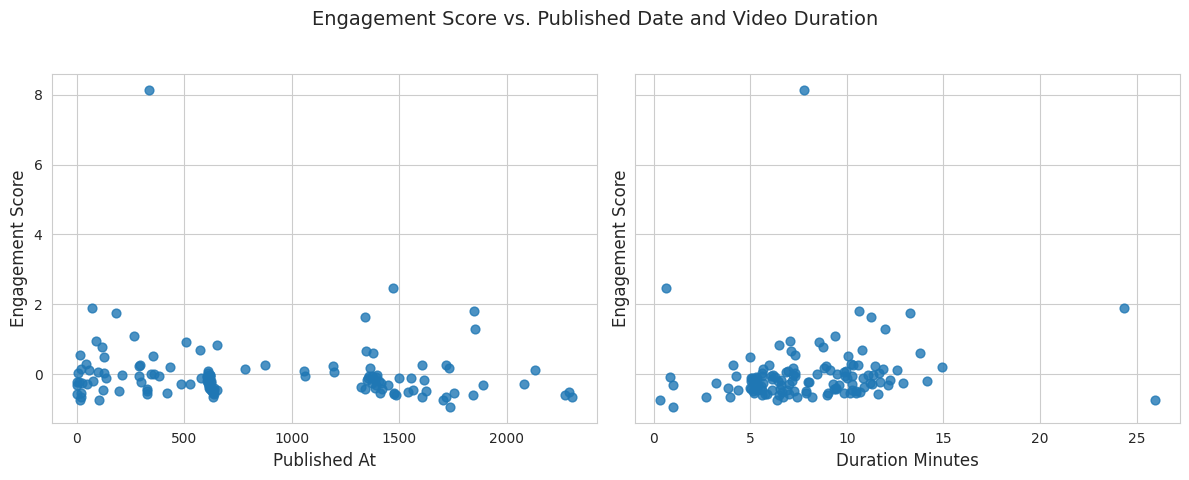

In [88]:
#plot the engagement score against the puiblished_at and duration_minutes
x_cols = ['published_at', 'duration_minutes']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, col in zip(axes, x_cols):
    ax.scatter(
        df[col],
        df['engagement_score'],
        alpha=0.8,
        s=40
    )
    ax.set_xlabel(col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Engagement Score', fontsize=12)
    ax.grid(True)

plt.suptitle('Engagement Score vs. Published Date and Video Duration', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# can include time as simple relation since no polynomial/nonlinear relationship obvious

In [93]:
# joint model controls for other metadata
X_joint = df[['pos_emotion',
              #'neg_emotion',
              'pct_with_face',
              'published_at',
              'duration_minutes']]
X_joint = sm.add_constant(X_joint)


y = df['engagement_score']

joint_model = sm.OLS(y, X_joint).fit()

print(joint_model.summary())

                            OLS Regression Results                            
Dep. Variable:       engagement_score   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.718
Date:                Tue, 13 May 2025   Prob (F-statistic):             0.0328
Time:                        23:24:01   Log-Likelihood:                -165.45
No. Observations:                 128   AIC:                             340.9
Df Residuals:                     123   BIC:                             355.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1445      0.383  


Option 2: Use PCA at cost of interpretability and explanatory power

In [95]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('video_data_final (128vids).csv')

# manipuilate timestamp to show time difference from frist scraped video to later ones
df['published_at'] = pd.to_datetime(df['published_at'])
df['published_at'] = df['published_at'].apply(lambda x: x.toordinal())
df['published_at'] = df['published_at'] - df['published_at'].min()

df['duration_minutes'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() / 60)


emotion_cols = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
metric_cols = ['views', 'likes', 'comments']
title_cols = ['title is exaggerated', 'title is emotionally touching', 'title is plain']

df['pos_emotion'] = df['happy'] + df['surprise']
df['neg_emotion'] = df['angry'] + df['disgust'] + df['fear'] + df['sad']

scaler = StandardScaler()
# scaling extracted features for pca
emotion_scaled = scaler.fit_transform(df[emotion_cols])
title_scaled = scaler.fit_transform(df[title_cols])

# scaling metadata and constructing engagement score for later analysis
df[['views_norm', 'likes_norm', 'comments_norm']] = scaler.fit_transform(df[metric_cols])
df['engagement_score'] = 0.34 * df['views_norm'] + 0.33 * df['likes_norm'] + 0.33 * df['comments_norm']


# pca on emotions - reduce into single dimension
pca = PCA(n_components=1)
emotion_pca = pca.fit_transform(emotion_scaled)

# we played around using multiple dimensions to reduce to but kept one as most reasonable
pca_cols = [f'emotion_pca_{i+1}' for i in range(emotion_pca.shape[1])]
df_pca = pd.DataFrame(emotion_pca, columns=pca_cols, index=df.index)
df = pd.concat([df, df_pca], axis=1)


# pca on title sentiment as well
title_pca = pca.fit_transform(title_scaled)
df['title_pca'] = title_pca


#df.head()

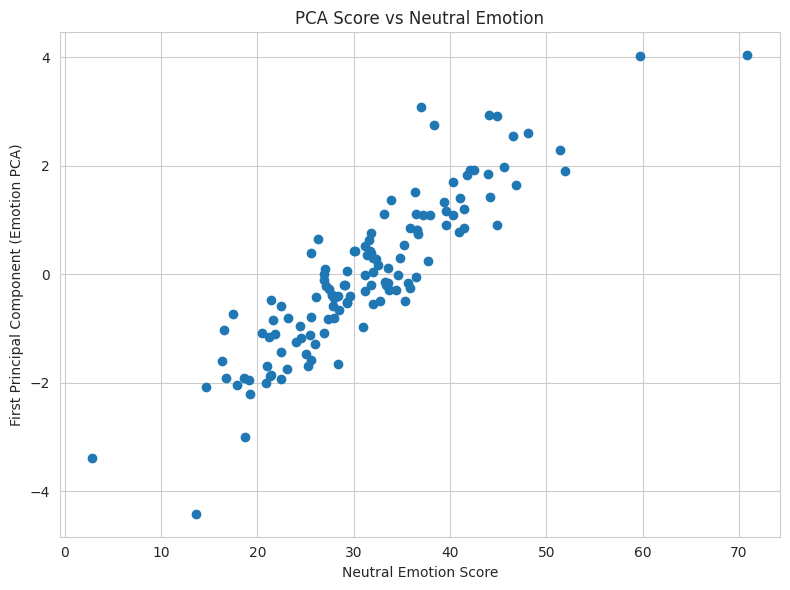

In [96]:
plt.figure(figsize=(8, 6))
plt.scatter(df['neutral'], df['emotion_pca_1'])
plt.xlabel('Neutral Emotion Score')
plt.ylabel('First Principal Component (Emotion PCA)')
plt.title('PCA Score vs Neutral Emotion')
plt.grid(True)
plt.tight_layout()
plt.show()


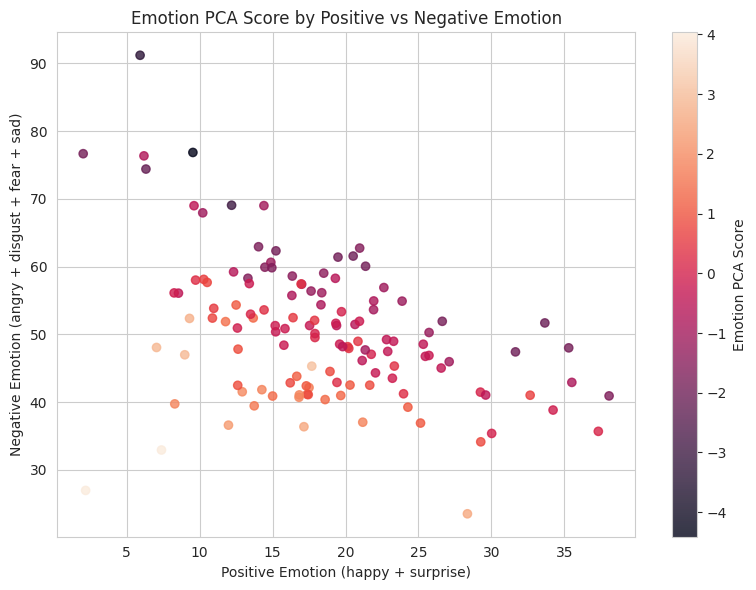

In [97]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df['pos_emotion'],
    df['neg_emotion'],
    c=df['emotion_pca_1'],
    alpha=0.8
)
plt.xlabel('Positive Emotion (happy + surprise)')
plt.ylabel('Negative Emotion (angry + disgust + fear + sad)')
plt.title('Emotion PCA Score by Positive vs Negative Emotion')
cbar = plt.colorbar(sc)
cbar.set_label('Emotion PCA Score')
plt.tight_layout()
plt.show()

<ipython-input-98-33e859e00656>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


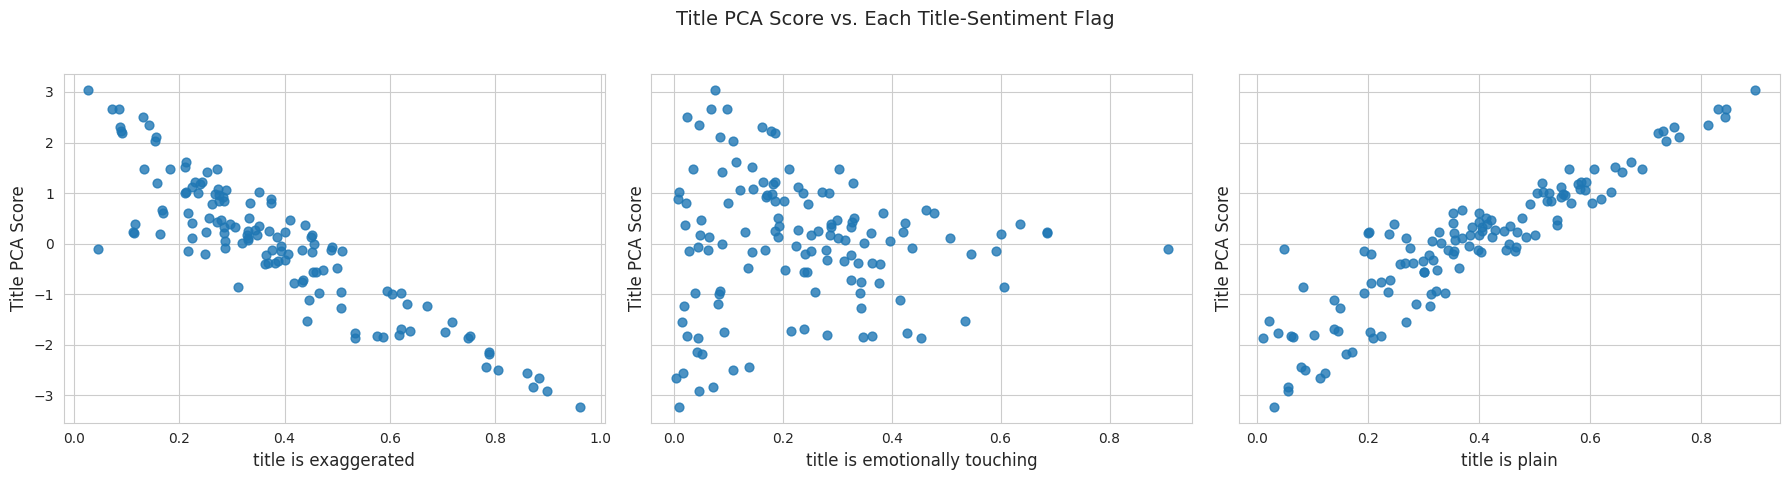

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, col in zip(axes, title_cols):
    sc = ax.scatter(
        df[col],
        df['title_pca'],
        cmap='viridis',
        alpha=0.8,
        s=40
    )
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Title PCA Score', fontsize=12)
    ax.grid(True)


plt.suptitle('Title PCA Score vs. Each Title-Sentiment Flag', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [99]:
X_cols = ['emotion_pca_1',
          'title_pca',
          'pct_with_face',
          'published_at',
          'duration_minutes'
          ]

# lin reg on egagement score (egagement = views & likes)
X = df[X_cols]
y = df['engagement_score']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

# while we do get a coefficient != 0 for the statistical modelling we cannot directly infer a causal relationship of including emotions in Youtube Videos to raise engagement.
# The statistical significance is likely influenced by our relatively small sample size which can be addressed by a larger project scope and at more computational expense.
# While we can interpret the values for the simple statistical models, the dimensionality reduction applied for our last model does not allow for good interpretation, since the score itself is difficult to interpret and does not follow a natural order.
# It merely tries to represent as much of the variance between the observations' (scaled) emotion scores

# we can also observe the video title seemingly having an impact on video engagement, sensible since title & thumbnail are first points of contact

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.756
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.127
Time:                        23:26:24   Log-Likelihood:                -166.42
No. Observations:                 128   AIC:                             344.8
Df Residuals:                     122   BIC:                             362.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3521      0.295     -1.192      0.236      -0.937       0.233
emotion_pca_1        0.0310      0.065      0.478      0.633      -0.097       0.159
title_pca            0.0849      0.064      1.324      0.188      -0.042       0.212
pct_with_face        0.0079      0.005      1.469      0.144      -0.003       0.019
published_at        -0.0001      0.000     -1.145      0.255      -0.000       0.000
duration_minutes     0.0219      0.024      0.920      0.360      -0.025       0.069
==============================================================================
Omnibus:                      194.123   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13662.242
Skew:                           6.012   Prob(JB):                         0.00
Kurtosis:                      52.164   Cond. No.                     3.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ML Pipeline for Prediction & Extraction of Feature Importance

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
import numpy as np
import shap

In [101]:
df = pd.read_csv('video_data_final (128vids).csv')

df['log_views'] = np.log1p(df['views'])
df['log_view_deviation'] = df['log_views'] - df['log_views'].mean()

# Feature engineer
# Maybe normalize or log transform view_deviation
df['published_at'] = pd.to_datetime(df['published_at'])
df['hour'] = df['published_at'].dt.hour
df['day_of_week'] = df['published_at'].dt.dayofweek
#df['month'] = df['published_at'].dt.month
df['duration_minutes'] = df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() / 60)

In [102]:
# Define features and target
X = df.drop(columns=['log_views', 'views', 'log_view_deviation', 'video_id', 'video_title', 'published_at', 'video_url', 'playlist_id', 'channel_title', 'likes', 'comments', 'duration', 'playlist_name'])
# Drop variables with low importance
# X = X.drop(columns=['day_of_week', 'brightness', 'title is plain', 'mean_g'])
# Fight positive skew
y = df['log_view_deviation']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.columns.tolist())

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'pct_with_face', 'brightness', 'mean_r', 'mean_g', 'mean_b', 'blurriness', 'title is plain', 'title is emotionally touching', 'title is exaggerated', 'hour', 'day_of_week', 'duration_minutes']


RMSE: 0.4647924108747296
R²: -0.09511442908032053


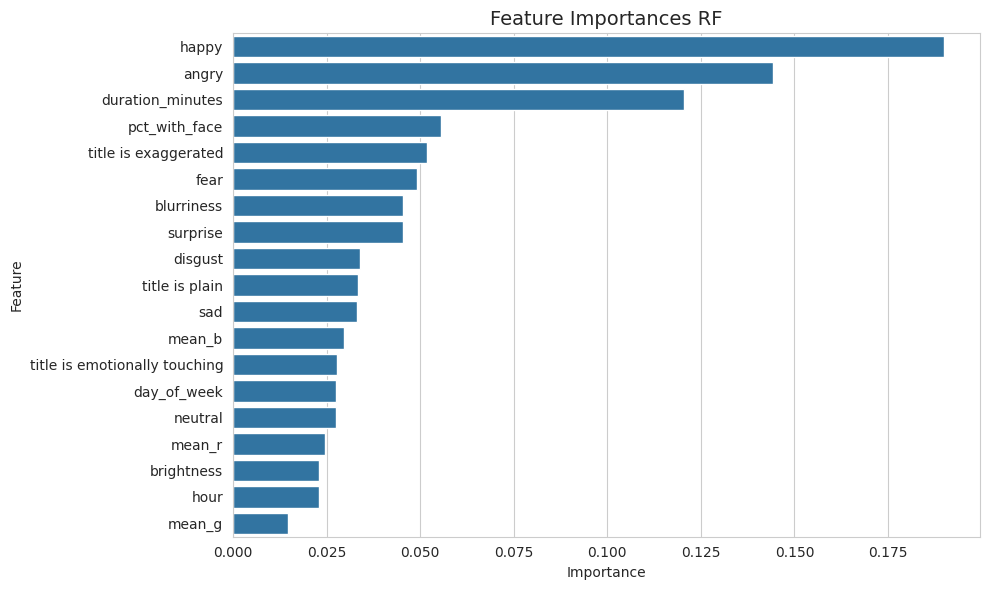

In [103]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))

importances = model.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature')
plt.title('Feature Importances RF', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

RMSE: 0.48299708300147315
R²: -0.13800712409045146


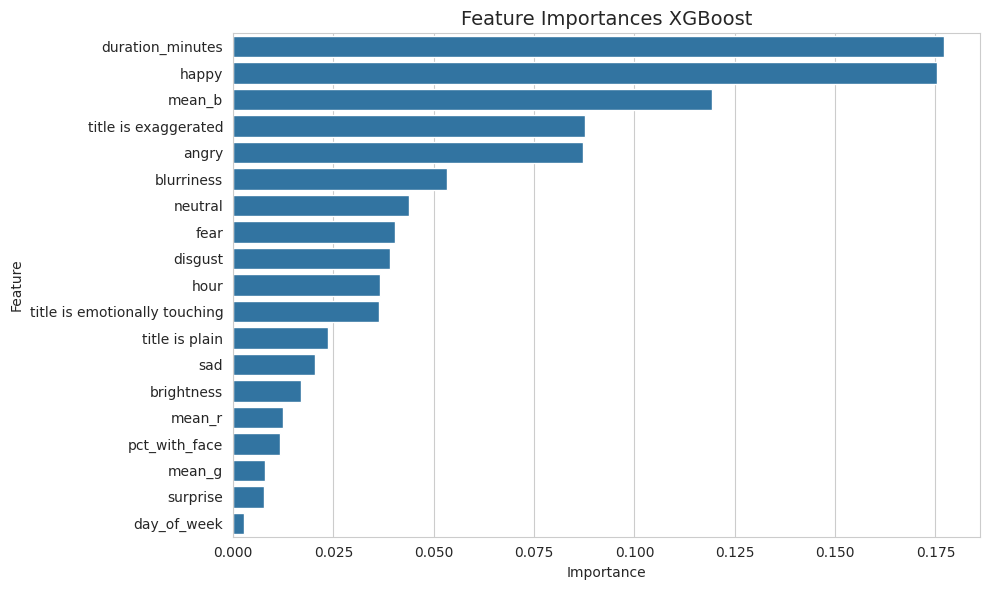

In [104]:
modelXG = xgb.XGBRegressor(random_state=42, verbosity=0)
modelXG.fit(X_train, y_train)

y_pred = modelXG.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))

importances = modelXG.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature')
plt.title('Feature Importances XGBoost', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Random Forest:


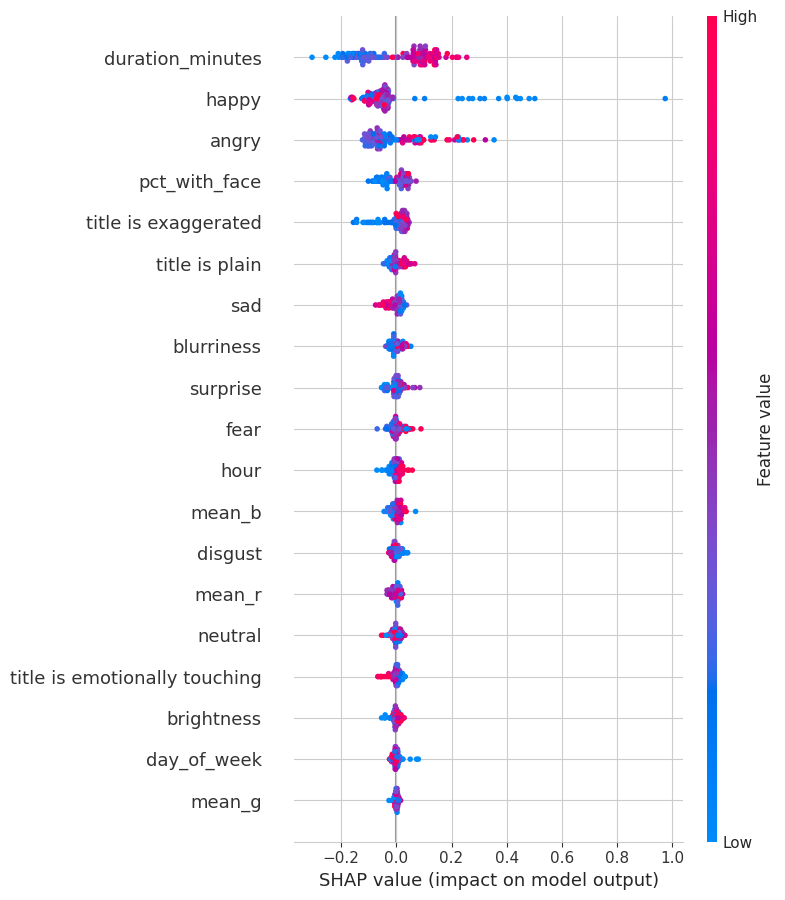

In [105]:
explainer = shap.TreeExplainer(model, X)
shap_values = explainer.shap_values(X, check_additivity=False)
print("Random Forest:")
shap.summary_plot(shap_values, X)

XGBoost:


<ipython-input-106-8d674569c69f>:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


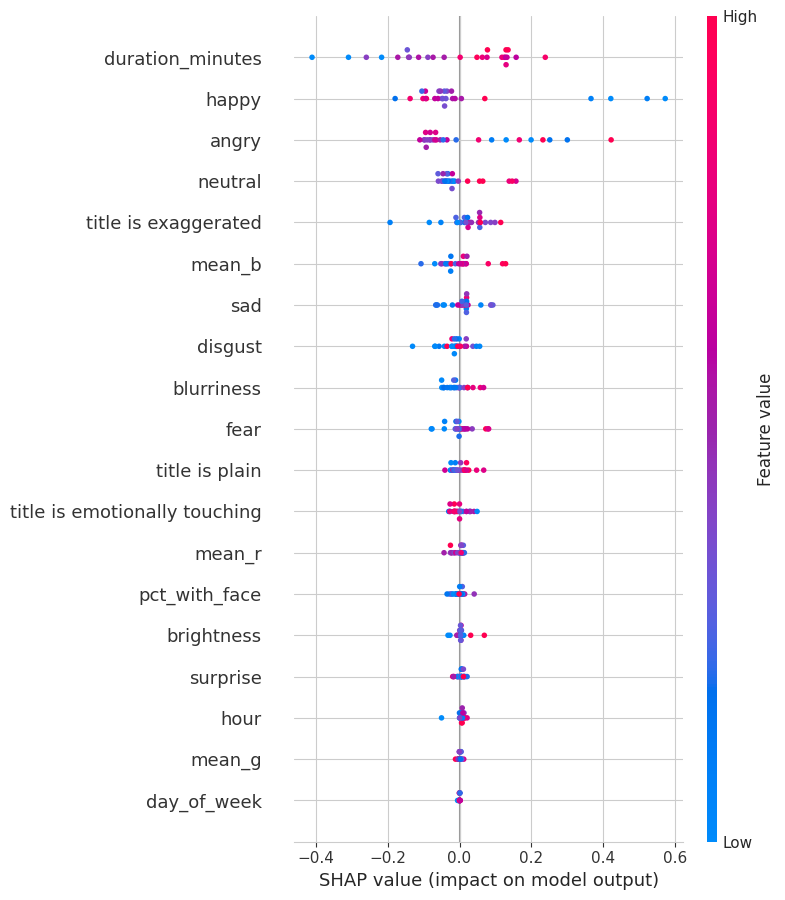

In [106]:
masker = shap.maskers.Independent(X_train)
explainer = shap.Explainer(modelXG.predict, masker)
shap_values = explainer(X_test)
print("XGBoost:")
shap.summary_plot(shap_values, X_test)